# Semi-supervised VAE on MNIST

This notebook contains experiments with semi-supervised VAE on MNIST data.

reference paper: https://arxiv.org/abs/1406.5298

** Requirements **

This notebook has been implemented using:

- Python 3.7.7
- Numpy 1.18.1
- Pandas 1.0.3
- Scipy 1.4.1
- PyTorch 1.4.0
- torchvision 0.5.0
- Scikit-Learn 0.22.1
- matplotlib 3.1.3
- seaborn 0.10.0

### Imports

In [1]:
# Python lib
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import random
from typing import List, Tuple, Optional
import types
import itertools

# Scientific utilities
import numpy as np
import pandas as pd
from scipy.stats import norm as ndist
from sklearn.metrics import confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.utils import make_grid

# Vizualisations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Globals

In [2]:
DATA_DIR = 'data'

BATCH_SIZE = 200

LABELED_DATA_SIZE = 0.05 # in percents

N_CLASSES = 10

** Fixing random seed for reproducibility **

In [3]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

### Preparing Data

Conveniently, PyTorch comes with pre-defined MNIST dataset so we are going to use it directly.

In [4]:
def get_mnist_ds(train: bool):
    
    seed_everything()

    ds = torchvision.datasets.MNIST(DATA_DIR, 
                                    train=train, 
                                    transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                              ]), 
                                    target_transform=None, 
                                    download=True)
    
    if not train:
        return ds
    
    # making sure that labeled portion of data has equal number of classes (thus making P(Y) uniform prior).
    
    sz = int(LABELED_DATA_SIZE * len(ds) / N_CLASSES)
    cnt = [0] * 10
    indices_l = []
    indices_u = []
    
    labels = list(zip(torch.LongTensor(ds.targets).tolist(), range(len(ds))))
    np.random.shuffle(labels) # shuffling data, just in case 
    
    for i in range(len(ds)):
        y, idx = labels[i]
        if cnt[y] != sz:
            cnt[y] += 1
            indices_l.append(idx)
        else:
            indices_u.append(idx)
        
    # making sure we partition the whole data into disjoint labelled/unlabelled subsets correctly.
    assert sorted(indices_l + indices_u) == list(range(len(ds)))
    
    # making sure we can distribute all of the data into equally-sized batches without leftover.
    assert len(indices_l) % BATCH_SIZE == 0
    assert len(indices_u) % BATCH_SIZE == 0
    
    return Subset(ds, indices_l), Subset(ds, indices_u)

def get_mnist_dls():
    """Returns separate DataLoaders per labelled/unlabelled and validation sets."""
    
    train_ds, train_ds_u = get_mnist_ds(train=True)
    
    valid_ds = get_mnist_ds(train=False)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True, 
                                        pin_memory=False, 
                                        drop_last=True),
            
            torch.utils.data.DataLoader(train_ds_u, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True, 
                                        pin_memory=False, 
                                        drop_last=True),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=4 * BATCH_SIZE, 
                                        shuffle=False, 
                                        pin_memory=False, 
                                        drop_last=False))

train_dl, train_dl_u, valid_dl = get_mnist_dls()

print("Number of labelled, unlabelled and valid samples: ", len(train_dl.dataset), 
                                                            len(train_dl_u.dataset), 
                                                            len(valid_dl.dataset)) 
      
print("Number of labelled, unlabelled and valid batches: ", len(train_dl), 
                                                            len(train_dl_u), 
                                                            len(valid_dl))

Number of labelled, unlabelled and valid samples:  3000 57000 10000
Number of labelled, unlabelled and valid batches:  15 285 13


**Showing a few samples from the dataset**

torch.Size([200, 1, 28, 28]) tensor(0.1308) tensor(0.3076) tensor(0.) tensor(1.)


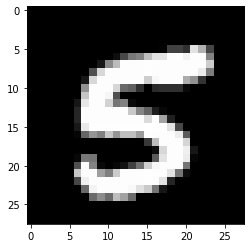

torch.Size([200, 1, 28, 28]) tensor(0.1343) tensor(0.3118) tensor(0.) tensor(1.)


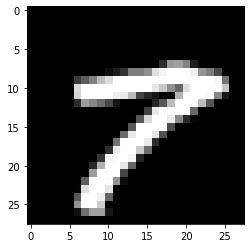

torch.Size([200, 1, 28, 28]) tensor(0.1298) tensor(0.3067) tensor(0.) tensor(1.)


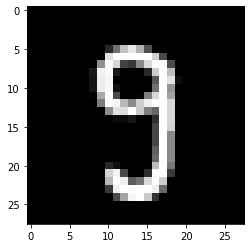

In [5]:
for i, (x, y) in enumerate(train_dl):
    print(x.shape, x.mean(), x.std(), x.min(), x.max())
    plt.imshow(x[0][0], cmap='gray')
    plt.show()
    if i > 1: break

### Defining Model

In [6]:
def init_weights(m: nn.Module):

    for m in m.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, a=0.02, nonlinearity='leaky_relu')
            nn.init.constant_(m.bias, 0)

def one_hot(y, n_classes: int) -> torch.FloatTensor:
    
    assert y.ndim <= 2
    
    bs = y.shape[0]
            
    y_onehot = torch.zeros(bs, n_classes, device=y.device).long()
    y_onehot.scatter_(1, y.view(bs, 1).long(), 1)
    
    return y_onehot.float()
    
class MLP(nn.Module):
    """Simple Multi-Layer Perceptron network."""
    
    def __init__(self, inp_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.layers = nn.Sequential(nn.Linear(inp_dim, hidden_dim),
                                    nn.LeakyReLU(0.02),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.LeakyReLU(0.02),
                                    nn.Dropout(0.2),
                                    nn.Linear(hidden_dim, out_dim))
        
        init_weights(self)
        
    def forward(self, x): return self.layers(x)

In [7]:
class SSVAE(nn.Module):
    """Semi-Supervised VAE"""
    
    def __init__(self, inp_shape: Tuple[int, int, int], 
                       hidden_dim: int,
                       out_dim: int, 
                       z_dim: int, 
                       n_classes: int):
        
        super().__init__()
        
        self.inp_shape = inp_shape
        self.n_classes = n_classes
        
        inp_dim = np.prod(inp_shape)
        
        self.enc = MLP(inp_dim + n_classes, hidden_dim, out_dim)
        self.dec = MLP(out_dim + n_classes, hidden_dim, inp_dim)
        
        self.cls = MLP(inp_dim, hidden_dim, n_classes)
        
        self.mu     = nn.Linear(out_dim, z_dim)
        self.logvar = nn.Linear(out_dim, z_dim)
        
        self.fc = nn.Linear(z_dim, out_dim)
        
        init_weights(self)
        
    def encode(self, x, y):
        
        inp = torch.cat([torch.flatten(x, 1), one_hot(y, self.n_classes)], dim=1)
        
        enc = self.enc(inp)
        
        return self.mu(enc), self.logvar(enc)
    
    def cls_logits(self, x):
        
        return self.cls(torch.flatten(x, 1))
        
    def sample_z(self, mu, logvar):
        """Applying Gaussian peparametrization trick"""
        
        eps = torch.empty_like(mu).normal_(0, 1)
        
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z, y):

        inp = torch.cat([self.fc(z), one_hot(y, self.n_classes)], dim=1)
        
        return self.dec(inp).view(-1, *self.inp_shape)
        
    def forward(self, x, y=None):
        
        if y is None:
            y = torch.argmax(self.cls_logits(x), dim=1)
        
        mu, logvar = self.encode(x, y)
        
        z = self.sample_z(mu, logvar)
        
        return self.decode(z, y)

### Defining Loss 

In [8]:
def kl_loss(mu, logvar):
    """KL_Divergence[N(mu, logvar.exp()), N(0, 1)]"""
    
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

def loss_xy(x, x_recon, mu, logvar):
    """returns negative ELBO(x, y) with y - label index."""
    
    bce = torch.nn.functional.binary_cross_entropy_with_logits(x_recon, x, reduction='none').sum(dim=(1, 2, 3))

    logPy = np.log(1.0 / N_CLASSES) # prior is uniform due to ballanced classes.
    
    kl = kl_loss(mu, logvar)
    
    return bce - logPy + kl

def loss_x(model: nn.Module, x, y_probs, mu, logvar):
    
    s, entropy = torch.zeros(mu.shape[0], device=mu.device), torch.zeros(mu.shape[0], device=mu.device)
    
    for i in range(y_probs.shape[-1]):
        
        y = torch.empty(x.shape[0], device=mu.device).fill_(i)

        x_recon = model.decode(model.sample_z(mu, logvar), y)
        
        s += y_probs[:, i] * loss_xy(x, x_recon, mu, logvar)
        
        entropy += y_probs[:,i] * y_probs[:,i].log()
        
    return (s + entropy).mean()

### Training Loop

In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n\nAccuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def get_preds(valid_dl: DataLoader, model: nn.Module):
    
    model.eval()
    model.cuda()
    
    y_preds, y_trues = [], []
    with torch.no_grad():
        for x, y in valid_dl:
            
            y_pred = torch.argmax(model.cls_logits(x.cuda()), dim=1).long().tolist()
            
            y_preds.extend(y_pred)
            y_trues.extend(y.tolist())
            
    model.train()
    
    return y_trues, y_preds

In [10]:
def try_get_batch(it):
    
    x, y = None, None
    try:
        x, y = next(it)
    except StopIteration:
        pass
    
    return x, y

def get_next_batch(train_dl, train_dl_u):
    """Returns a next batch, either labelled or unlabelled, making equal gaps between alternations."""

    it_l, it_u = iter(train_dl), iter(train_dl_u)
    
    for i in range(1, 1 << 30):
        
        unlabelled = i % (len(train_dl_u) // len(train_dl)) != 0
        
        if unlabelled:
            x, y = try_get_batch(it_u)
            has_label = False
            
        if (not unlabelled) or (x is None):
            x, y = try_get_batch(it_l)
            has_label = True
        
        if x is None:
            return None, None, has_label
            
        yield x, y, has_label

In [11]:
class MetricLogger:
    """Helper class for logging metrics"""
    
    def __init__(self, name, init_val = 0):
        
        self.name = name
        self.init_val = init_val
        
        self.counter = 0
        
        self.logs = []
        
    def log(self, val):
        
        self.logs.append(val)
        
        self.counter += 1
        
    def reset(self):
        self.counter = 0
        
    @property
    def val(self):
        
        data = self.logs[len(self.logs) - self.counter:]
        
        mean, std = np.mean(data), np.std(data) 
        
        return f"Avg %s: %.5f (±%.3f)" % (self.name, mean, std)
    
    def plot(self):
        plt.title(self.name)
        plt.plot(self.logs)

In [12]:
def show_summary(valid_dl: DataLoader, model: nn.Module, acc_logger: Optional[MetricLogger] = None):
    """This is a helper function for visualizing model output quality during the training process."""
    
    N_SAMPLES = 15
    
    model.eval()
    
    actuals, preds = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl.dataset):
            
            actuals.append(x)
                        
            recon_x = model(x.cuda(), torch.Tensor([y]).cuda()).sigmoid().cpu()
            
            preds.append(recon_x.view(*x.shape))
            
            if i + 1 == N_SAMPLES:
                break
                            
    grid = make_grid([*actuals, *preds], pad_value=1, padding=1, nrow=N_SAMPLES)

    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show() 
    
    y_trues, y_preds = get_preds(valid_dl, model)
    
    cm = confusion_matrix(y_trues, y_preds)
    
    if acc_logger:
        acc_logger.log(np.trace(cm) / float(np.sum(cm)))
    
    plot_confusion_matrix(cm, target_names=[str(i) for i in range(10)])
    
    model.train()

def train_vae(train_dl: DataLoader, 
              train_dl_u: DataLoader,
              valid_dl: DataLoader,
              model: nn.Module,
              n_epochs: int,
              loss_logger: MetricLogger,
              cls_loss_logger: MetricLogger,
              acc_logger: MetricLogger,
              max_iters: int = -1):
    
    LOG_INTERVAL = 20
    SUMMARY_INTERVAL = 200
    
    CLS_LOSS_WEIGHT = 0.1 * len(train_dl.dataset) # as in paper
    
    model = model.cuda()
    
    cls_crit = nn.CrossEntropyLoss()
    
    model.train()
    
    optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
    
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)
    
    for epoch in range(n_epochs):
        
        for i, (x, y, has_label) in enumerate(get_next_batch(train_dl, train_dl_u)):
            
            if x is None: break
        
            optim.zero_grad()
            
            x = x.cuda()
            y = y.cuda()
            
            y_logits = model.cls_logits(x)
            
            cls_loss = cls_crit(y_logits, y)

            if has_label:
                
                mu, logvar = model.encode(x, y)
                
                z = model.sample_z(mu, logvar)

                x_recon = model.decode(z, y)

                loss = loss_xy(x, x_recon, mu, logvar).mean() + CLS_LOSS_WEIGHT * cls_loss
                
            else:
                
                mu, logvar = model.encode(x, torch.argmax(y_logits, dim=1))
                
                loss = loss_x(model, x, y_logits.softmax(dim=1), mu, logvar)

            loss_logger.log(loss.item())
            cls_loss_logger.log(cls_loss.item())
            
            loss.backward()
            
            optim.step()
            
            if (i + 1) % LOG_INTERVAL == 0:
                
                print('epoch %d | iter %d | %s | %s' % (epoch + 1, i + 1, loss_logger.val, cls_loss_logger.val))
                
                loss_logger.reset()
                cls_loss_logger.reset()
                
            if (i + 1) % SUMMARY_INTERVAL == 0:
                show_summary(valid_dl, model, acc_logger)
            
            if i == max_iters:
                return
            
        lr_scheduler.step()

In [13]:
seed_everything()
vae = SSVAE(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256, z_dim=2, n_classes=10)

epoch 1 | iter 20 | Avg Loss: 437.52955 (±269.013) | Avg Cls Loss: 2.80338 (±0.163)
epoch 1 | iter 40 | Avg Loss: 265.77576 (±177.507) | Avg Cls Loss: 2.58893 (±0.235)
epoch 1 | iter 60 | Avg Loss: 242.08277 (±137.502) | Avg Cls Loss: 1.98875 (±0.191)
epoch 1 | iter 80 | Avg Loss: 230.01530 (±116.853) | Avg Cls Loss: 1.64712 (±0.141)
epoch 1 | iter 100 | Avg Loss: 218.50044 (±85.642) | Avg Cls Loss: 1.16046 (±0.116)
epoch 1 | iter 120 | Avg Loss: 209.83831 (±62.163) | Avg Cls Loss: 0.89180 (±0.125)
epoch 1 | iter 140 | Avg Loss: 207.86608 (±64.637) | Avg Cls Loss: 0.77304 (±0.099)
epoch 1 | iter 160 | Avg Loss: 207.42716 (±75.904) | Avg Cls Loss: 0.96296 (±0.226)
epoch 1 | iter 180 | Avg Loss: 203.00986 (±70.203) | Avg Cls Loss: 0.93075 (±0.128)
epoch 1 | iter 200 | Avg Loss: 204.83899 (±88.627) | Avg Cls Loss: 0.88192 (±0.216)


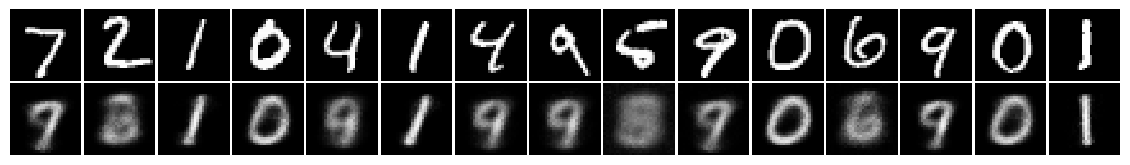

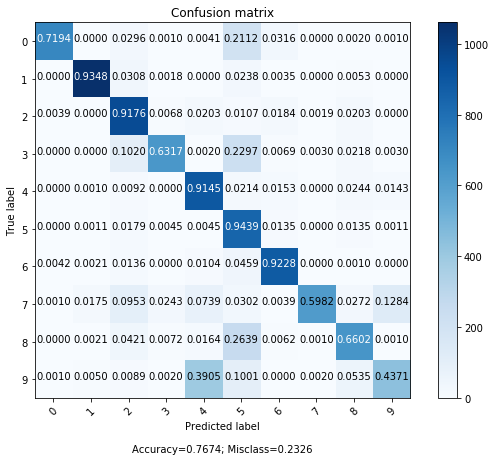

epoch 1 | iter 220 | Avg Loss: 194.04532 (±66.732) | Avg Cls Loss: 0.76333 (±0.127)
epoch 1 | iter 240 | Avg Loss: 187.32291 (±50.546) | Avg Cls Loss: 0.68836 (±0.149)
epoch 1 | iter 260 | Avg Loss: 183.05221 (±45.653) | Avg Cls Loss: 0.55991 (±0.114)
epoch 1 | iter 280 | Avg Loss: 178.99842 (±41.653) | Avg Cls Loss: 0.49725 (±0.070)
epoch 1 | iter 300 | Avg Loss: 177.15861 (±37.092) | Avg Cls Loss: 0.46565 (±0.083)
epoch 2 | iter 20 | Avg Loss: 170.65342 (±20.647) | Avg Cls Loss: 0.46009 (±0.072)
epoch 2 | iter 40 | Avg Loss: 169.84016 (±24.422) | Avg Cls Loss: 0.38906 (±0.072)
epoch 2 | iter 60 | Avg Loss: 167.21746 (±17.943) | Avg Cls Loss: 0.38892 (±0.081)
epoch 2 | iter 80 | Avg Loss: 167.73183 (±25.283) | Avg Cls Loss: 0.38685 (±0.078)
epoch 2 | iter 100 | Avg Loss: 166.41671 (±23.193) | Avg Cls Loss: 0.44446 (±0.076)
epoch 2 | iter 120 | Avg Loss: 164.95628 (±23.757) | Avg Cls Loss: 0.38460 (±0.081)
epoch 2 | iter 140 | Avg Loss: 165.48916 (±30.653) | Avg Cls Loss: 0.40188 (±0.0

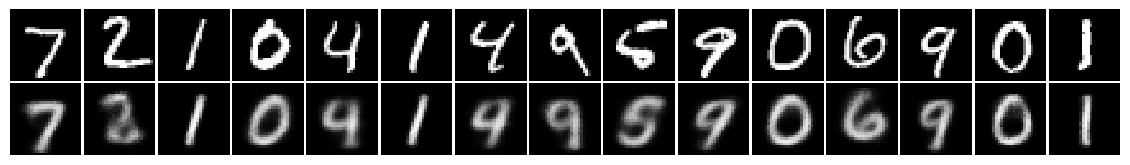

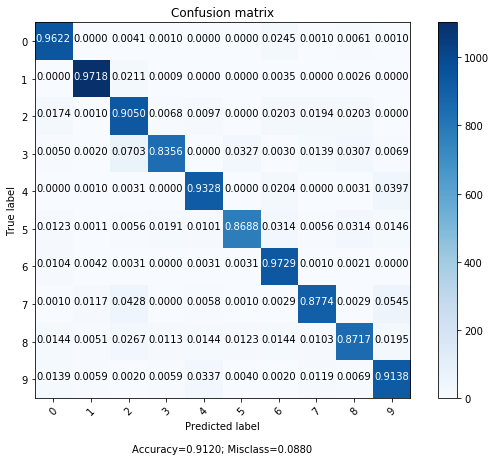

epoch 2 | iter 220 | Avg Loss: 161.59601 (±31.294) | Avg Cls Loss: 0.33617 (±0.059)
epoch 2 | iter 240 | Avg Loss: 158.22223 (±22.760) | Avg Cls Loss: 0.30791 (±0.049)
epoch 2 | iter 260 | Avg Loss: 157.98950 (±26.287) | Avg Cls Loss: 0.34280 (±0.060)
epoch 2 | iter 280 | Avg Loss: 157.42110 (±19.820) | Avg Cls Loss: 0.30854 (±0.065)
epoch 2 | iter 300 | Avg Loss: 157.61417 (±23.264) | Avg Cls Loss: 0.43964 (±0.114)
epoch 3 | iter 20 | Avg Loss: 159.48235 (±32.334) | Avg Cls Loss: 0.60187 (±0.098)
epoch 3 | iter 40 | Avg Loss: 154.29910 (±14.537) | Avg Cls Loss: 0.36485 (±0.087)
epoch 3 | iter 60 | Avg Loss: 152.69071 (±13.917) | Avg Cls Loss: 0.30313 (±0.105)
epoch 3 | iter 80 | Avg Loss: 152.81207 (±16.861) | Avg Cls Loss: 0.28936 (±0.072)
epoch 3 | iter 100 | Avg Loss: 155.02611 (±26.874) | Avg Cls Loss: 0.56386 (±0.188)
epoch 3 | iter 120 | Avg Loss: 154.43408 (±17.462) | Avg Cls Loss: 0.35664 (±0.113)
epoch 3 | iter 140 | Avg Loss: 152.65062 (±19.292) | Avg Cls Loss: 0.31884 (±0.0

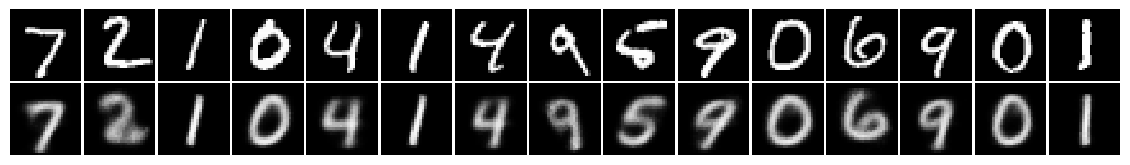

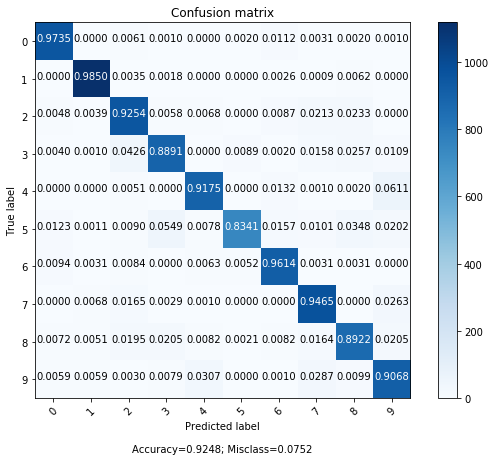

epoch 3 | iter 220 | Avg Loss: 149.95877 (±12.202) | Avg Cls Loss: 0.29746 (±0.102)
epoch 3 | iter 240 | Avg Loss: 153.27151 (±21.895) | Avg Cls Loss: 0.33044 (±0.066)
epoch 3 | iter 260 | Avg Loss: 151.41484 (±21.423) | Avg Cls Loss: 0.35042 (±0.100)
epoch 3 | iter 280 | Avg Loss: 150.03991 (±17.359) | Avg Cls Loss: 0.30981 (±0.068)
epoch 3 | iter 300 | Avg Loss: 148.60044 (±12.703) | Avg Cls Loss: 0.29477 (±0.094)
epoch 4 | iter 20 | Avg Loss: 147.48638 (±5.256) | Avg Cls Loss: 0.27209 (±0.086)
epoch 4 | iter 40 | Avg Loss: 146.38051 (±9.584) | Avg Cls Loss: 0.27577 (±0.062)
epoch 4 | iter 60 | Avg Loss: 149.36968 (±14.700) | Avg Cls Loss: 0.32143 (±0.093)
epoch 4 | iter 80 | Avg Loss: 147.07463 (±7.566) | Avg Cls Loss: 0.26943 (±0.065)
epoch 4 | iter 100 | Avg Loss: 147.40205 (±7.226) | Avg Cls Loss: 0.27221 (±0.089)
epoch 4 | iter 120 | Avg Loss: 144.95018 (±4.669) | Avg Cls Loss: 0.25049 (±0.087)
epoch 4 | iter 140 | Avg Loss: 145.76726 (±8.503) | Avg Cls Loss: 0.24327 (±0.087)
ep

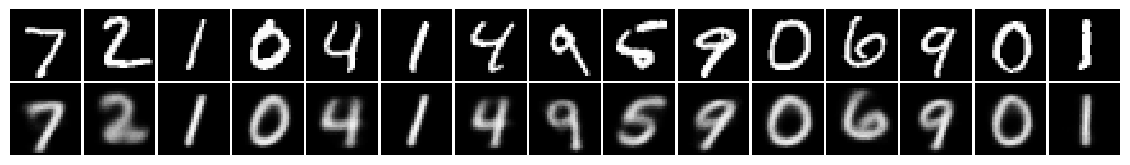

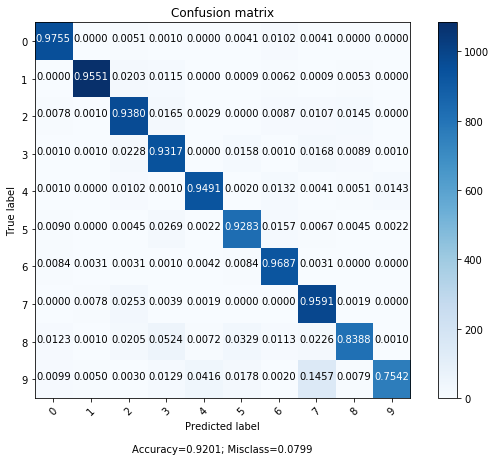

epoch 4 | iter 220 | Avg Loss: 146.25375 (±13.140) | Avg Cls Loss: 0.29214 (±0.112)
epoch 4 | iter 240 | Avg Loss: 146.43141 (±12.888) | Avg Cls Loss: 0.30078 (±0.102)
epoch 4 | iter 260 | Avg Loss: 147.90497 (±16.424) | Avg Cls Loss: 0.31905 (±0.095)
epoch 4 | iter 280 | Avg Loss: 147.87323 (±13.280) | Avg Cls Loss: 0.32981 (±0.108)
epoch 4 | iter 300 | Avg Loss: 146.57732 (±12.997) | Avg Cls Loss: 0.24421 (±0.081)
epoch 5 | iter 20 | Avg Loss: 142.90963 (±4.162) | Avg Cls Loss: 0.22514 (±0.088)
epoch 5 | iter 40 | Avg Loss: 143.79094 (±4.509) | Avg Cls Loss: 0.24233 (±0.084)
epoch 5 | iter 60 | Avg Loss: 143.99389 (±6.262) | Avg Cls Loss: 0.25004 (±0.101)
epoch 5 | iter 80 | Avg Loss: 144.60129 (±9.036) | Avg Cls Loss: 0.29141 (±0.098)
epoch 5 | iter 100 | Avg Loss: 143.96538 (±6.318) | Avg Cls Loss: 0.29483 (±0.110)
epoch 5 | iter 120 | Avg Loss: 144.50799 (±4.930) | Avg Cls Loss: 0.26771 (±0.083)
epoch 5 | iter 140 | Avg Loss: 144.24784 (±9.848) | Avg Cls Loss: 0.24904 (±0.069)
epo

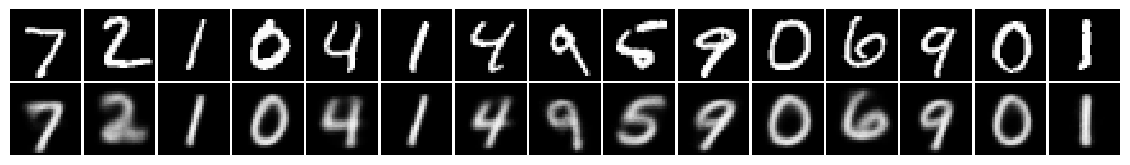

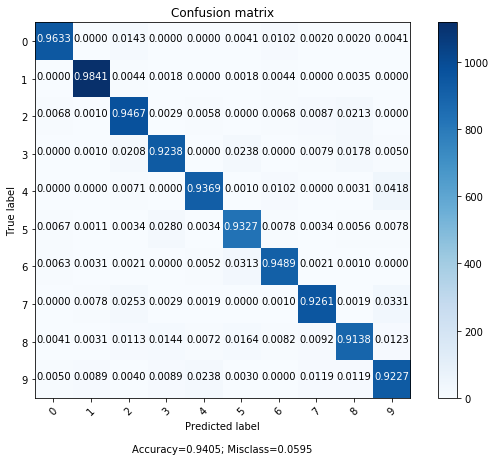

epoch 5 | iter 220 | Avg Loss: 142.60024 (±3.925) | Avg Cls Loss: 0.26219 (±0.087)
epoch 5 | iter 240 | Avg Loss: 142.07222 (±6.283) | Avg Cls Loss: 0.23728 (±0.078)
epoch 5 | iter 260 | Avg Loss: 143.19353 (±8.001) | Avg Cls Loss: 0.28410 (±0.066)
epoch 5 | iter 280 | Avg Loss: 143.64178 (±7.041) | Avg Cls Loss: 0.31058 (±0.112)
epoch 5 | iter 300 | Avg Loss: 141.58336 (±3.593) | Avg Cls Loss: 0.26746 (±0.146)
epoch 6 | iter 20 | Avg Loss: 140.77169 (±3.188) | Avg Cls Loss: 0.27561 (±0.091)
epoch 6 | iter 40 | Avg Loss: 141.31616 (±5.008) | Avg Cls Loss: 0.26808 (±0.100)
epoch 6 | iter 60 | Avg Loss: 141.33857 (±3.548) | Avg Cls Loss: 0.27824 (±0.128)
epoch 6 | iter 80 | Avg Loss: 139.93382 (±3.700) | Avg Cls Loss: 0.26742 (±0.106)
epoch 6 | iter 100 | Avg Loss: 139.86468 (±3.503) | Avg Cls Loss: 0.23170 (±0.106)
epoch 6 | iter 120 | Avg Loss: 139.51334 (±3.596) | Avg Cls Loss: 0.26460 (±0.097)
epoch 6 | iter 140 | Avg Loss: 139.78127 (±2.734) | Avg Cls Loss: 0.22349 (±0.086)
epoch 6 

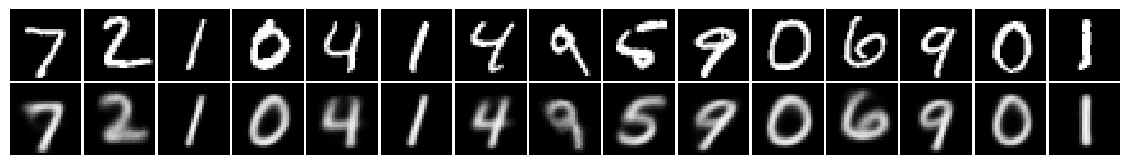

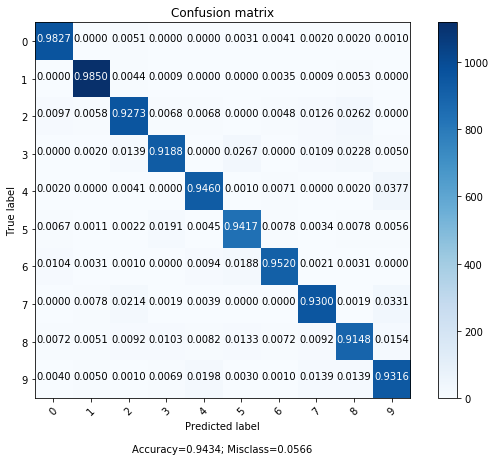

epoch 6 | iter 220 | Avg Loss: 139.20161 (±4.044) | Avg Cls Loss: 0.27377 (±0.117)
epoch 6 | iter 240 | Avg Loss: 139.65279 (±3.048) | Avg Cls Loss: 0.25143 (±0.098)
epoch 6 | iter 260 | Avg Loss: 140.60232 (±4.701) | Avg Cls Loss: 0.27583 (±0.092)
epoch 6 | iter 280 | Avg Loss: 139.42730 (±4.067) | Avg Cls Loss: 0.27292 (±0.084)
epoch 6 | iter 300 | Avg Loss: 141.03630 (±3.879) | Avg Cls Loss: 0.28801 (±0.111)
epoch 7 | iter 20 | Avg Loss: 140.42681 (±3.932) | Avg Cls Loss: 0.28057 (±0.093)
epoch 7 | iter 40 | Avg Loss: 140.28533 (±3.134) | Avg Cls Loss: 0.30303 (±0.130)
epoch 7 | iter 60 | Avg Loss: 138.89857 (±3.033) | Avg Cls Loss: 0.24452 (±0.111)
epoch 7 | iter 80 | Avg Loss: 138.23179 (±3.825) | Avg Cls Loss: 0.29148 (±0.130)
epoch 7 | iter 100 | Avg Loss: 138.26661 (±2.708) | Avg Cls Loss: 0.27037 (±0.094)
epoch 7 | iter 120 | Avg Loss: 138.13829 (±2.917) | Avg Cls Loss: 0.29582 (±0.116)
epoch 7 | iter 140 | Avg Loss: 139.23616 (±3.609) | Avg Cls Loss: 0.26800 (±0.129)
epoch 7 

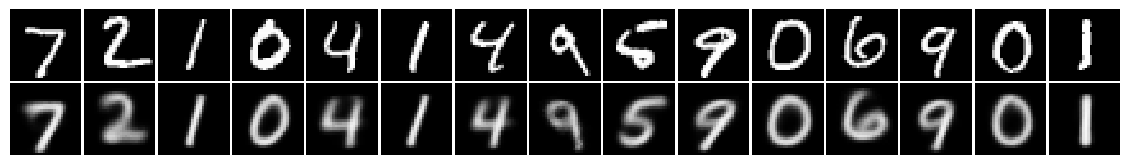

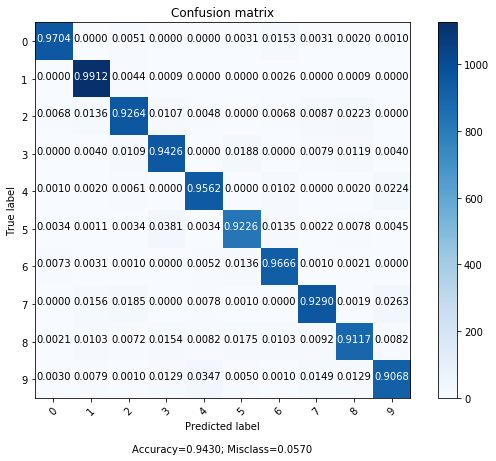

epoch 7 | iter 220 | Avg Loss: 138.14007 (±3.420) | Avg Cls Loss: 0.30398 (±0.117)
epoch 7 | iter 240 | Avg Loss: 138.47257 (±3.201) | Avg Cls Loss: 0.30481 (±0.130)
epoch 7 | iter 260 | Avg Loss: 139.37106 (±2.983) | Avg Cls Loss: 0.26994 (±0.108)
epoch 7 | iter 280 | Avg Loss: 140.86150 (±3.669) | Avg Cls Loss: 0.26631 (±0.113)
epoch 7 | iter 300 | Avg Loss: 139.22358 (±3.642) | Avg Cls Loss: 0.23716 (±0.100)
epoch 8 | iter 20 | Avg Loss: 138.73169 (±3.342) | Avg Cls Loss: 0.28865 (±0.116)
epoch 8 | iter 40 | Avg Loss: 138.80137 (±3.642) | Avg Cls Loss: 0.26537 (±0.123)
epoch 8 | iter 60 | Avg Loss: 137.65980 (±2.571) | Avg Cls Loss: 0.25635 (±0.090)
epoch 8 | iter 80 | Avg Loss: 138.68892 (±3.300) | Avg Cls Loss: 0.31483 (±0.121)
epoch 8 | iter 100 | Avg Loss: 138.25328 (±3.461) | Avg Cls Loss: 0.28615 (±0.113)
epoch 8 | iter 120 | Avg Loss: 139.18267 (±3.127) | Avg Cls Loss: 0.27696 (±0.113)
epoch 8 | iter 140 | Avg Loss: 137.66895 (±2.187) | Avg Cls Loss: 0.26900 (±0.111)
epoch 8 

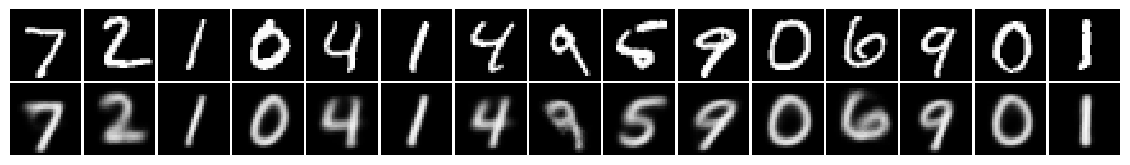

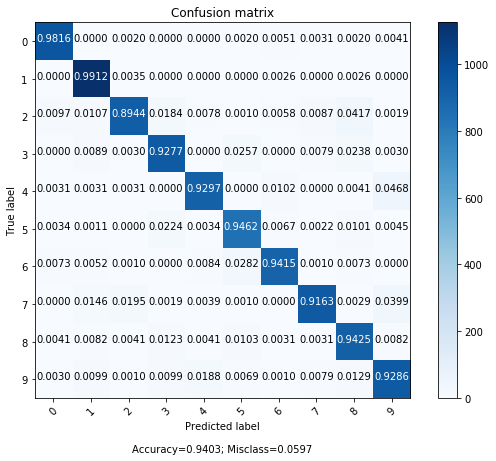

epoch 8 | iter 220 | Avg Loss: 138.55758 (±3.924) | Avg Cls Loss: 0.32221 (±0.120)
epoch 8 | iter 240 | Avg Loss: 138.85093 (±3.477) | Avg Cls Loss: 0.28190 (±0.126)
epoch 8 | iter 260 | Avg Loss: 139.07720 (±3.228) | Avg Cls Loss: 0.29546 (±0.108)
epoch 8 | iter 280 | Avg Loss: 138.28100 (±2.454) | Avg Cls Loss: 0.28369 (±0.106)
epoch 8 | iter 300 | Avg Loss: 139.47780 (±3.766) | Avg Cls Loss: 0.30355 (±0.125)
epoch 9 | iter 20 | Avg Loss: 139.30991 (±3.718) | Avg Cls Loss: 0.33988 (±0.113)
epoch 9 | iter 40 | Avg Loss: 138.88663 (±3.625) | Avg Cls Loss: 0.33236 (±0.123)
epoch 9 | iter 60 | Avg Loss: 138.44150 (±2.999) | Avg Cls Loss: 0.27873 (±0.113)
epoch 9 | iter 80 | Avg Loss: 137.47105 (±3.195) | Avg Cls Loss: 0.31716 (±0.105)
epoch 9 | iter 100 | Avg Loss: 136.57790 (±3.802) | Avg Cls Loss: 0.32336 (±0.138)
epoch 9 | iter 120 | Avg Loss: 136.89070 (±3.875) | Avg Cls Loss: 0.28607 (±0.111)
epoch 9 | iter 140 | Avg Loss: 137.97666 (±1.876) | Avg Cls Loss: 0.33763 (±0.135)
epoch 9 

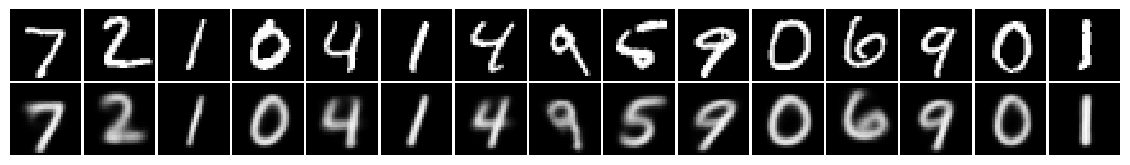

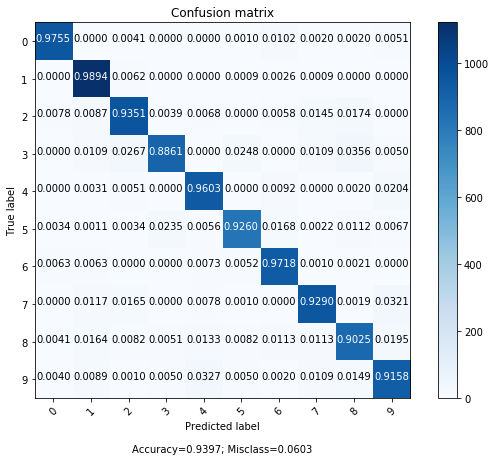

epoch 9 | iter 220 | Avg Loss: 138.20716 (±3.624) | Avg Cls Loss: 0.30207 (±0.124)
epoch 9 | iter 240 | Avg Loss: 138.31695 (±3.934) | Avg Cls Loss: 0.32777 (±0.150)
epoch 9 | iter 260 | Avg Loss: 138.63089 (±2.791) | Avg Cls Loss: 0.26492 (±0.139)
epoch 9 | iter 280 | Avg Loss: 138.21977 (±3.665) | Avg Cls Loss: 0.34967 (±0.137)
epoch 9 | iter 300 | Avg Loss: 137.56152 (±3.531) | Avg Cls Loss: 0.33045 (±0.112)
epoch 10 | iter 20 | Avg Loss: 136.66408 (±2.316) | Avg Cls Loss: 0.33199 (±0.132)
epoch 10 | iter 40 | Avg Loss: 137.64971 (±3.701) | Avg Cls Loss: 0.31045 (±0.120)
epoch 10 | iter 60 | Avg Loss: 137.50260 (±2.503) | Avg Cls Loss: 0.32782 (±0.139)
epoch 10 | iter 80 | Avg Loss: 136.75074 (±2.982) | Avg Cls Loss: 0.34511 (±0.122)
epoch 10 | iter 100 | Avg Loss: 137.06471 (±3.629) | Avg Cls Loss: 0.33851 (±0.136)
epoch 10 | iter 120 | Avg Loss: 138.16894 (±4.110) | Avg Cls Loss: 0.35250 (±0.133)
epoch 10 | iter 140 | Avg Loss: 137.19702 (±4.034) | Avg Cls Loss: 0.28595 (±0.097)
e

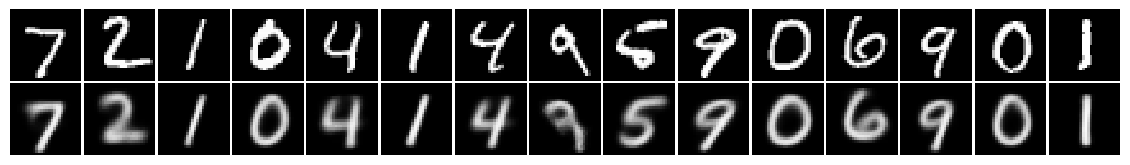

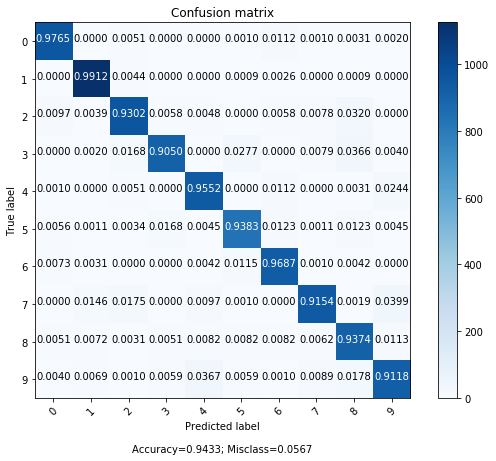

epoch 10 | iter 220 | Avg Loss: 137.49623 (±2.582) | Avg Cls Loss: 0.32364 (±0.128)
epoch 10 | iter 240 | Avg Loss: 139.39825 (±3.639) | Avg Cls Loss: 0.32438 (±0.130)
epoch 10 | iter 260 | Avg Loss: 138.85817 (±4.197) | Avg Cls Loss: 0.28875 (±0.114)
epoch 10 | iter 280 | Avg Loss: 136.55448 (±2.977) | Avg Cls Loss: 0.35394 (±0.128)
epoch 10 | iter 300 | Avg Loss: 137.34243 (±2.619) | Avg Cls Loss: 0.33781 (±0.134)
epoch 11 | iter 20 | Avg Loss: 136.98316 (±3.099) | Avg Cls Loss: 0.37033 (±0.176)
epoch 11 | iter 40 | Avg Loss: 136.09255 (±3.228) | Avg Cls Loss: 0.31674 (±0.157)
epoch 11 | iter 60 | Avg Loss: 137.12524 (±3.265) | Avg Cls Loss: 0.31292 (±0.122)
epoch 11 | iter 80 | Avg Loss: 136.88465 (±3.926) | Avg Cls Loss: 0.28084 (±0.145)
epoch 11 | iter 100 | Avg Loss: 135.66665 (±3.536) | Avg Cls Loss: 0.32329 (±0.133)
epoch 11 | iter 120 | Avg Loss: 136.84567 (±3.417) | Avg Cls Loss: 0.31211 (±0.125)
epoch 11 | iter 140 | Avg Loss: 136.27508 (±3.400) | Avg Cls Loss: 0.30435 (±0.1

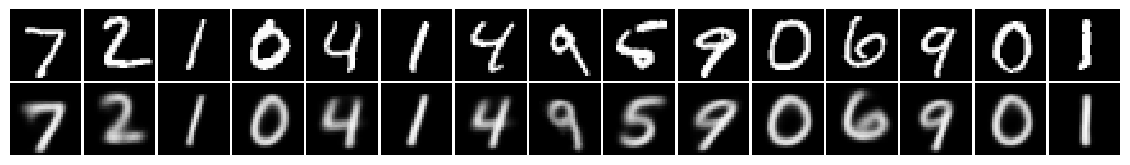

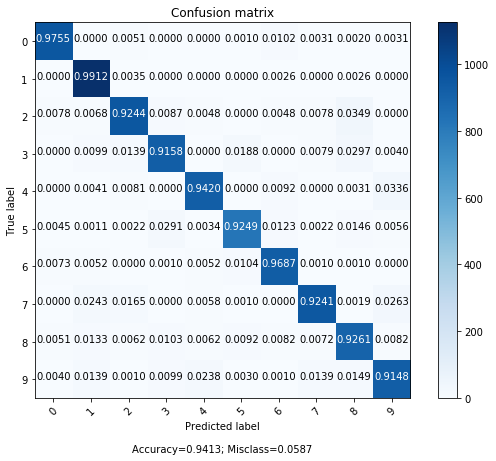

epoch 11 | iter 220 | Avg Loss: 135.43186 (±2.908) | Avg Cls Loss: 0.32960 (±0.145)
epoch 11 | iter 240 | Avg Loss: 137.10304 (±2.943) | Avg Cls Loss: 0.32306 (±0.141)
epoch 11 | iter 260 | Avg Loss: 136.55193 (±1.752) | Avg Cls Loss: 0.30220 (±0.166)
epoch 11 | iter 280 | Avg Loss: 136.53248 (±3.187) | Avg Cls Loss: 0.32545 (±0.151)
epoch 11 | iter 300 | Avg Loss: 136.19516 (±2.542) | Avg Cls Loss: 0.38095 (±0.190)
epoch 12 | iter 20 | Avg Loss: 135.72411 (±3.286) | Avg Cls Loss: 0.35237 (±0.159)
epoch 12 | iter 40 | Avg Loss: 135.55356 (±3.142) | Avg Cls Loss: 0.34582 (±0.147)
epoch 12 | iter 60 | Avg Loss: 136.49868 (±3.268) | Avg Cls Loss: 0.32155 (±0.126)
epoch 12 | iter 80 | Avg Loss: 135.64317 (±4.200) | Avg Cls Loss: 0.35602 (±0.148)
epoch 12 | iter 100 | Avg Loss: 137.23482 (±2.588) | Avg Cls Loss: 0.33597 (±0.159)
epoch 12 | iter 120 | Avg Loss: 134.85018 (±3.926) | Avg Cls Loss: 0.38629 (±0.152)
epoch 12 | iter 140 | Avg Loss: 136.03360 (±3.023) | Avg Cls Loss: 0.35190 (±0.1

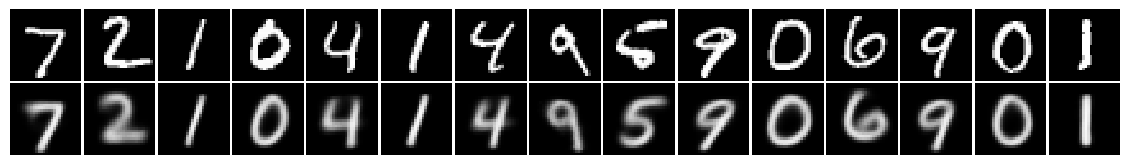

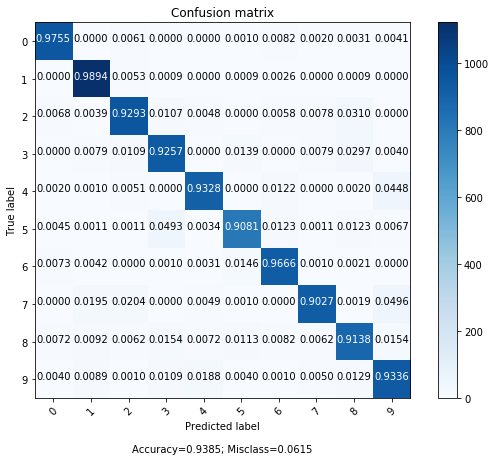

epoch 12 | iter 220 | Avg Loss: 135.62140 (±3.029) | Avg Cls Loss: 0.34507 (±0.130)
epoch 12 | iter 240 | Avg Loss: 135.39486 (±2.675) | Avg Cls Loss: 0.35431 (±0.137)
epoch 12 | iter 260 | Avg Loss: 136.67620 (±2.906) | Avg Cls Loss: 0.35967 (±0.143)
epoch 12 | iter 280 | Avg Loss: 135.79087 (±2.919) | Avg Cls Loss: 0.34491 (±0.146)
epoch 12 | iter 300 | Avg Loss: 136.61361 (±2.677) | Avg Cls Loss: 0.35528 (±0.140)
epoch 13 | iter 20 | Avg Loss: 136.12275 (±3.764) | Avg Cls Loss: 0.34800 (±0.158)
epoch 13 | iter 40 | Avg Loss: 136.33865 (±2.065) | Avg Cls Loss: 0.33756 (±0.153)
epoch 13 | iter 60 | Avg Loss: 135.53758 (±2.811) | Avg Cls Loss: 0.36807 (±0.137)
epoch 13 | iter 80 | Avg Loss: 135.83036 (±3.651) | Avg Cls Loss: 0.38363 (±0.178)
epoch 13 | iter 100 | Avg Loss: 134.97737 (±2.726) | Avg Cls Loss: 0.33763 (±0.146)
epoch 13 | iter 120 | Avg Loss: 135.48627 (±3.585) | Avg Cls Loss: 0.37790 (±0.141)
epoch 13 | iter 140 | Avg Loss: 135.16959 (±4.125) | Avg Cls Loss: 0.37946 (±0.1

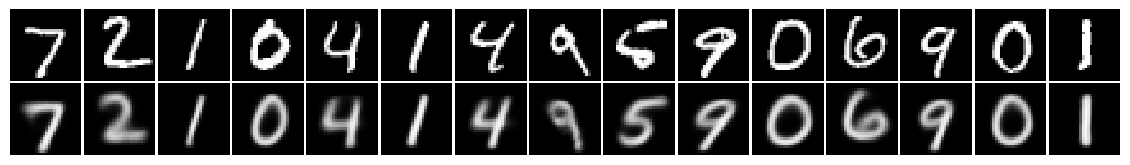

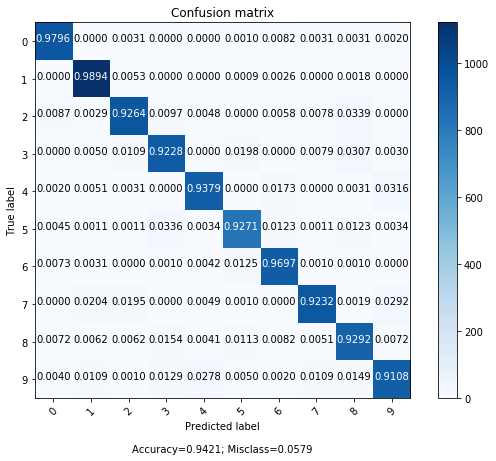

epoch 13 | iter 220 | Avg Loss: 136.09447 (±3.673) | Avg Cls Loss: 0.34313 (±0.135)
epoch 13 | iter 240 | Avg Loss: 136.78812 (±2.866) | Avg Cls Loss: 0.37099 (±0.169)
epoch 13 | iter 260 | Avg Loss: 134.99477 (±3.000) | Avg Cls Loss: 0.36010 (±0.147)
epoch 13 | iter 280 | Avg Loss: 134.58293 (±3.422) | Avg Cls Loss: 0.31884 (±0.151)
epoch 13 | iter 300 | Avg Loss: 135.84113 (±2.962) | Avg Cls Loss: 0.36749 (±0.136)
epoch 14 | iter 20 | Avg Loss: 135.16845 (±2.860) | Avg Cls Loss: 0.34536 (±0.135)
epoch 14 | iter 40 | Avg Loss: 135.81467 (±3.075) | Avg Cls Loss: 0.34318 (±0.142)
epoch 14 | iter 60 | Avg Loss: 135.68491 (±3.760) | Avg Cls Loss: 0.37271 (±0.123)
epoch 14 | iter 80 | Avg Loss: 136.72374 (±2.681) | Avg Cls Loss: 0.33428 (±0.131)
epoch 14 | iter 100 | Avg Loss: 134.61376 (±3.933) | Avg Cls Loss: 0.41910 (±0.162)
epoch 14 | iter 120 | Avg Loss: 135.39805 (±3.643) | Avg Cls Loss: 0.37734 (±0.152)
epoch 14 | iter 140 | Avg Loss: 136.50748 (±2.886) | Avg Cls Loss: 0.38994 (±0.1

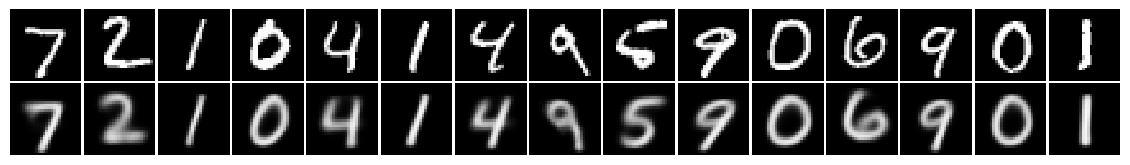

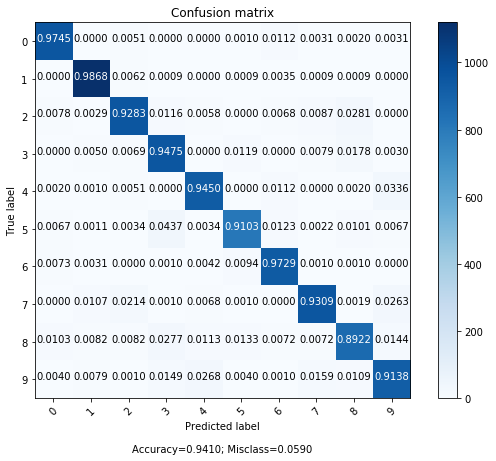

epoch 14 | iter 220 | Avg Loss: 135.12535 (±4.493) | Avg Cls Loss: 0.34361 (±0.112)
epoch 14 | iter 240 | Avg Loss: 136.16903 (±2.619) | Avg Cls Loss: 0.37785 (±0.177)
epoch 14 | iter 260 | Avg Loss: 135.96641 (±2.713) | Avg Cls Loss: 0.35353 (±0.155)
epoch 14 | iter 280 | Avg Loss: 136.34095 (±3.617) | Avg Cls Loss: 0.31979 (±0.105)
epoch 14 | iter 300 | Avg Loss: 135.19647 (±2.386) | Avg Cls Loss: 0.38625 (±0.137)
epoch 15 | iter 20 | Avg Loss: 134.91748 (±3.764) | Avg Cls Loss: 0.37471 (±0.179)
epoch 15 | iter 40 | Avg Loss: 133.94051 (±2.638) | Avg Cls Loss: 0.35805 (±0.138)
epoch 15 | iter 60 | Avg Loss: 137.39008 (±2.870) | Avg Cls Loss: 0.43059 (±0.206)
epoch 15 | iter 80 | Avg Loss: 135.25253 (±2.495) | Avg Cls Loss: 0.34987 (±0.156)
epoch 15 | iter 100 | Avg Loss: 135.91033 (±2.686) | Avg Cls Loss: 0.34043 (±0.155)
epoch 15 | iter 120 | Avg Loss: 136.56613 (±3.503) | Avg Cls Loss: 0.40725 (±0.143)
epoch 15 | iter 140 | Avg Loss: 135.84041 (±2.676) | Avg Cls Loss: 0.39643 (±0.1

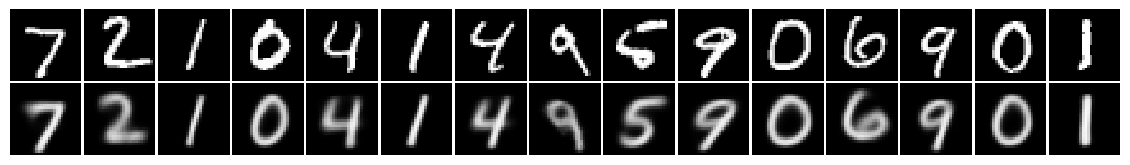

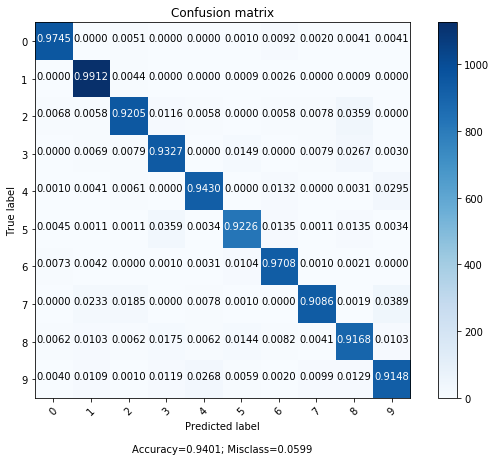

epoch 15 | iter 220 | Avg Loss: 135.05737 (±2.811) | Avg Cls Loss: 0.38228 (±0.140)
epoch 15 | iter 240 | Avg Loss: 134.91775 (±3.279) | Avg Cls Loss: 0.43386 (±0.153)
epoch 15 | iter 260 | Avg Loss: 135.50221 (±2.954) | Avg Cls Loss: 0.39813 (±0.151)
epoch 15 | iter 280 | Avg Loss: 136.22144 (±2.301) | Avg Cls Loss: 0.38727 (±0.170)
epoch 15 | iter 300 | Avg Loss: 134.71687 (±3.949) | Avg Cls Loss: 0.35738 (±0.114)
epoch 16 | iter 20 | Avg Loss: 135.67976 (±2.167) | Avg Cls Loss: 0.38676 (±0.177)
epoch 16 | iter 40 | Avg Loss: 134.69503 (±2.757) | Avg Cls Loss: 0.42765 (±0.162)
epoch 16 | iter 60 | Avg Loss: 134.96788 (±3.401) | Avg Cls Loss: 0.37687 (±0.167)
epoch 16 | iter 80 | Avg Loss: 134.80464 (±2.369) | Avg Cls Loss: 0.39057 (±0.171)
epoch 16 | iter 100 | Avg Loss: 135.03801 (±2.623) | Avg Cls Loss: 0.37510 (±0.140)
epoch 16 | iter 120 | Avg Loss: 134.62516 (±3.827) | Avg Cls Loss: 0.43864 (±0.163)
epoch 16 | iter 140 | Avg Loss: 134.48052 (±2.734) | Avg Cls Loss: 0.42884 (±0.1

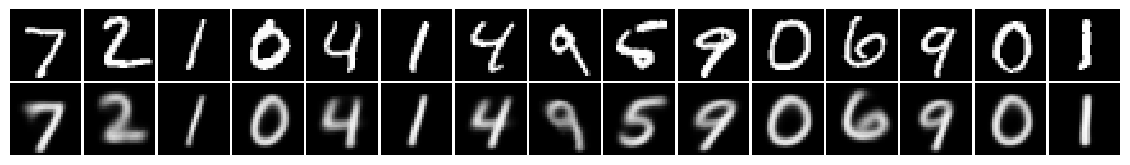

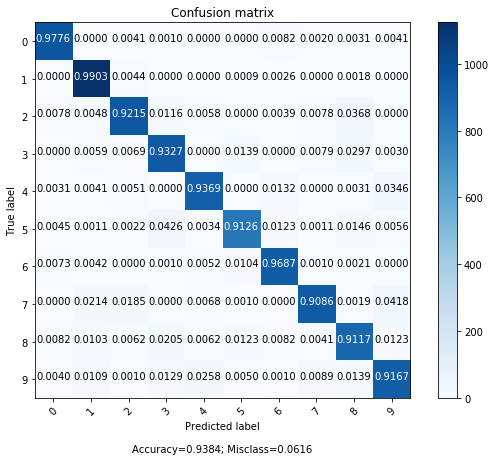

epoch 16 | iter 220 | Avg Loss: 134.80700 (±2.898) | Avg Cls Loss: 0.38735 (±0.141)
epoch 16 | iter 240 | Avg Loss: 134.86726 (±3.212) | Avg Cls Loss: 0.35560 (±0.149)
epoch 16 | iter 260 | Avg Loss: 134.26487 (±2.916) | Avg Cls Loss: 0.37479 (±0.128)
epoch 16 | iter 280 | Avg Loss: 134.44224 (±2.558) | Avg Cls Loss: 0.40123 (±0.184)
epoch 16 | iter 300 | Avg Loss: 136.21747 (±2.064) | Avg Cls Loss: 0.43479 (±0.235)
epoch 17 | iter 20 | Avg Loss: 134.55080 (±2.553) | Avg Cls Loss: 0.36635 (±0.146)
epoch 17 | iter 40 | Avg Loss: 135.09819 (±2.512) | Avg Cls Loss: 0.41462 (±0.181)
epoch 17 | iter 60 | Avg Loss: 134.61515 (±2.929) | Avg Cls Loss: 0.42194 (±0.156)
epoch 17 | iter 80 | Avg Loss: 134.98329 (±3.701) | Avg Cls Loss: 0.44296 (±0.181)
epoch 17 | iter 100 | Avg Loss: 134.14594 (±2.915) | Avg Cls Loss: 0.35786 (±0.150)
epoch 17 | iter 120 | Avg Loss: 134.59729 (±3.699) | Avg Cls Loss: 0.40965 (±0.165)
epoch 17 | iter 140 | Avg Loss: 134.47522 (±3.243) | Avg Cls Loss: 0.39415 (±0.1

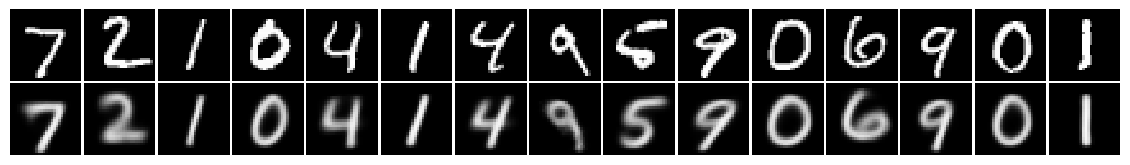

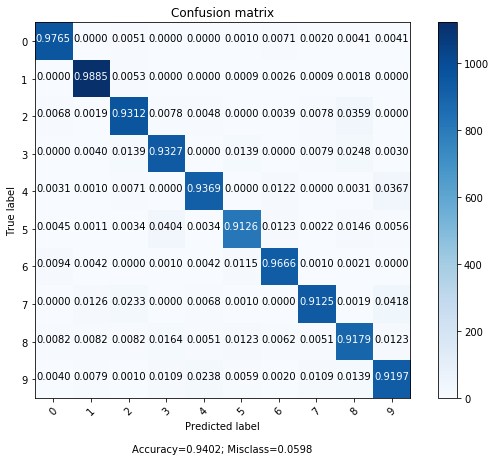

epoch 17 | iter 220 | Avg Loss: 135.08639 (±3.185) | Avg Cls Loss: 0.43346 (±0.162)
epoch 17 | iter 240 | Avg Loss: 134.90233 (±3.268) | Avg Cls Loss: 0.40142 (±0.136)
epoch 17 | iter 260 | Avg Loss: 135.60377 (±3.485) | Avg Cls Loss: 0.38759 (±0.153)
epoch 17 | iter 280 | Avg Loss: 135.03723 (±2.659) | Avg Cls Loss: 0.33327 (±0.126)
epoch 17 | iter 300 | Avg Loss: 134.65623 (±3.184) | Avg Cls Loss: 0.38461 (±0.172)
epoch 18 | iter 20 | Avg Loss: 133.84666 (±3.685) | Avg Cls Loss: 0.39350 (±0.169)
epoch 18 | iter 40 | Avg Loss: 135.83871 (±3.259) | Avg Cls Loss: 0.43479 (±0.162)
epoch 18 | iter 60 | Avg Loss: 132.00543 (±2.238) | Avg Cls Loss: 0.42599 (±0.159)
epoch 18 | iter 80 | Avg Loss: 134.82472 (±2.760) | Avg Cls Loss: 0.37808 (±0.132)
epoch 18 | iter 100 | Avg Loss: 135.52262 (±2.319) | Avg Cls Loss: 0.38125 (±0.165)
epoch 18 | iter 120 | Avg Loss: 135.82146 (±2.561) | Avg Cls Loss: 0.44140 (±0.202)
epoch 18 | iter 140 | Avg Loss: 133.78893 (±2.511) | Avg Cls Loss: 0.40247 (±0.1

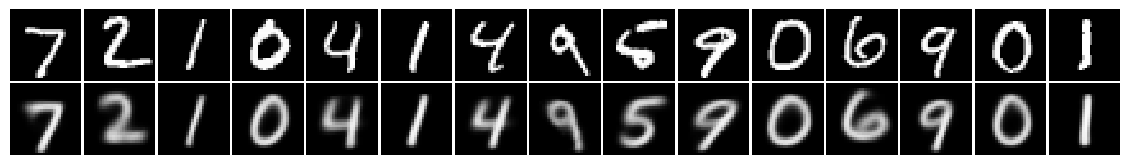

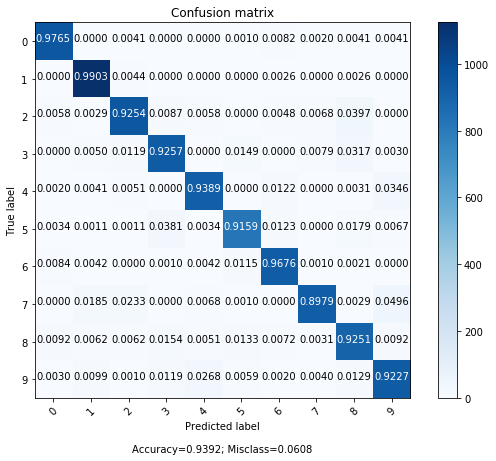

epoch 18 | iter 220 | Avg Loss: 136.31310 (±2.234) | Avg Cls Loss: 0.34865 (±0.126)
epoch 18 | iter 240 | Avg Loss: 134.54602 (±2.825) | Avg Cls Loss: 0.41579 (±0.154)
epoch 18 | iter 260 | Avg Loss: 135.18250 (±3.702) | Avg Cls Loss: 0.40032 (±0.169)
epoch 18 | iter 280 | Avg Loss: 133.98508 (±3.584) | Avg Cls Loss: 0.41444 (±0.162)
epoch 18 | iter 300 | Avg Loss: 134.54664 (±3.368) | Avg Cls Loss: 0.34365 (±0.133)
epoch 19 | iter 20 | Avg Loss: 135.47366 (±3.032) | Avg Cls Loss: 0.37444 (±0.132)
epoch 19 | iter 40 | Avg Loss: 133.62189 (±2.893) | Avg Cls Loss: 0.37793 (±0.176)
epoch 19 | iter 60 | Avg Loss: 134.92768 (±2.762) | Avg Cls Loss: 0.40868 (±0.166)
epoch 19 | iter 80 | Avg Loss: 134.51555 (±3.134) | Avg Cls Loss: 0.43825 (±0.220)
epoch 19 | iter 100 | Avg Loss: 134.45866 (±2.645) | Avg Cls Loss: 0.32988 (±0.151)
epoch 19 | iter 120 | Avg Loss: 134.36756 (±3.996) | Avg Cls Loss: 0.44380 (±0.125)
epoch 19 | iter 140 | Avg Loss: 135.45456 (±3.318) | Avg Cls Loss: 0.41374 (±0.1

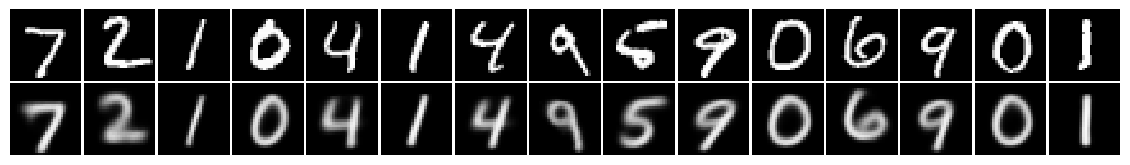

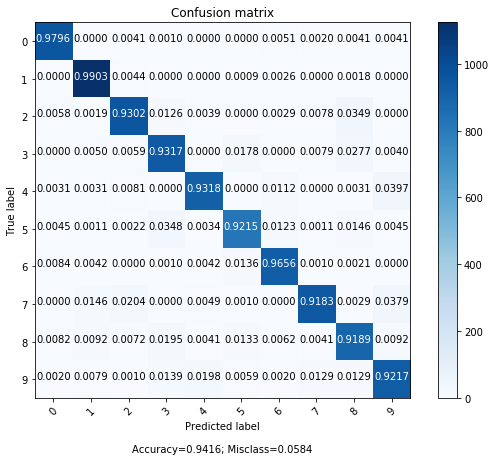

epoch 19 | iter 220 | Avg Loss: 134.66414 (±2.489) | Avg Cls Loss: 0.41862 (±0.176)
epoch 19 | iter 240 | Avg Loss: 133.41175 (±3.368) | Avg Cls Loss: 0.44227 (±0.161)
epoch 19 | iter 260 | Avg Loss: 134.51976 (±4.311) | Avg Cls Loss: 0.42983 (±0.192)
epoch 19 | iter 280 | Avg Loss: 134.30139 (±3.590) | Avg Cls Loss: 0.39338 (±0.160)
epoch 19 | iter 300 | Avg Loss: 134.32847 (±2.551) | Avg Cls Loss: 0.40507 (±0.163)
epoch 20 | iter 20 | Avg Loss: 134.24403 (±2.751) | Avg Cls Loss: 0.41945 (±0.172)
epoch 20 | iter 40 | Avg Loss: 134.32544 (±2.778) | Avg Cls Loss: 0.41474 (±0.140)
epoch 20 | iter 60 | Avg Loss: 134.68157 (±3.049) | Avg Cls Loss: 0.40246 (±0.160)
epoch 20 | iter 80 | Avg Loss: 135.56427 (±2.912) | Avg Cls Loss: 0.39747 (±0.165)
epoch 20 | iter 100 | Avg Loss: 134.77277 (±3.144) | Avg Cls Loss: 0.41474 (±0.160)
epoch 20 | iter 120 | Avg Loss: 133.99823 (±4.086) | Avg Cls Loss: 0.37502 (±0.153)
epoch 20 | iter 140 | Avg Loss: 132.94186 (±2.693) | Avg Cls Loss: 0.34953 (±0.1

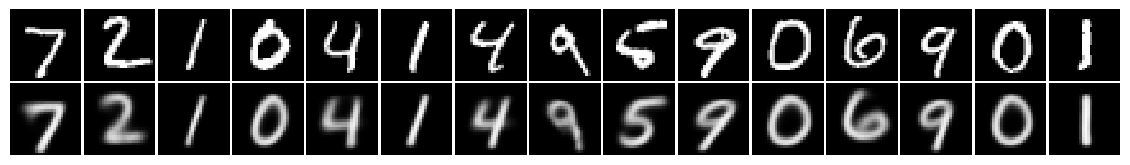

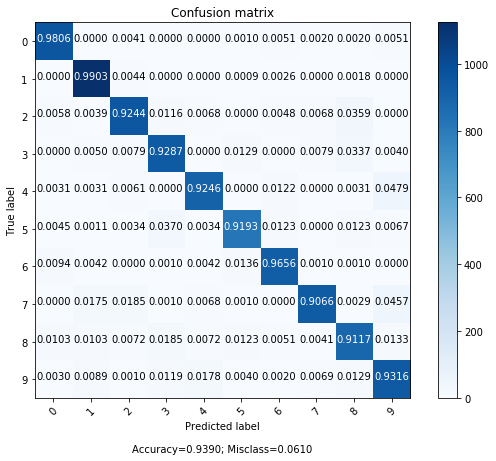

epoch 20 | iter 220 | Avg Loss: 134.07814 (±3.527) | Avg Cls Loss: 0.42714 (±0.182)
epoch 20 | iter 240 | Avg Loss: 134.87015 (±4.081) | Avg Cls Loss: 0.40702 (±0.193)
epoch 20 | iter 260 | Avg Loss: 133.34001 (±2.168) | Avg Cls Loss: 0.38773 (±0.164)
epoch 20 | iter 280 | Avg Loss: 134.33026 (±2.450) | Avg Cls Loss: 0.41292 (±0.162)
epoch 20 | iter 300 | Avg Loss: 134.17861 (±3.126) | Avg Cls Loss: 0.41514 (±0.157)


In [14]:
loss_logger = MetricLogger("Loss")
cls_loss_logger = MetricLogger("Cls Loss")
acc_logger = MetricLogger('Accuracy')

train_vae(train_dl, train_dl_u, valid_dl, vae, 20, loss_logger, cls_loss_logger, acc_logger)

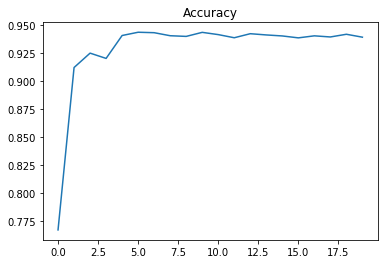

In [15]:
acc_logger.plot()

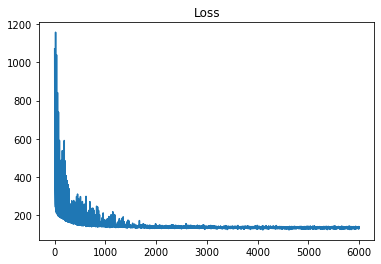

In [16]:
loss_logger.plot()

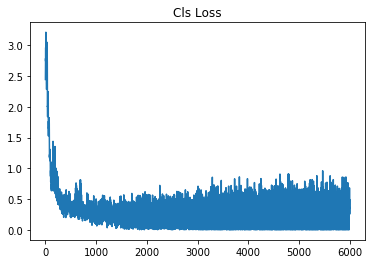

In [17]:
cls_loss_logger.plot()

## Visualizing Results

### VIsualize 2D Latent Space (centers of Gaussian)

In [18]:
def get_df_for_viz(vae: nn.Module):

    vae.cuda()
    z, z_vars, labels = [], [], []
    
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl):
            mu, logvar = vae.encode(x.cuda(), y.cuda())
            mu = mu.cpu()
            var = logvar.exp().cpu()
            z.append(mu)
            labels.append(y)
            z_vars.append(var[:,0] + var[:,1])
            
    z = torch.cat(z, dim=0)
    labels = torch.cat(labels, dim=0)
    z_vars = torch.cat(z_vars, dim=0)

    df = pd.DataFrame({'x': z[:,0].numpy(), 
                       'y': z[:,1].numpy(),
                       'tot_var': z_vars.numpy(),
                       'label': labels.numpy()})

    return df

df = get_df_for_viz(vae)

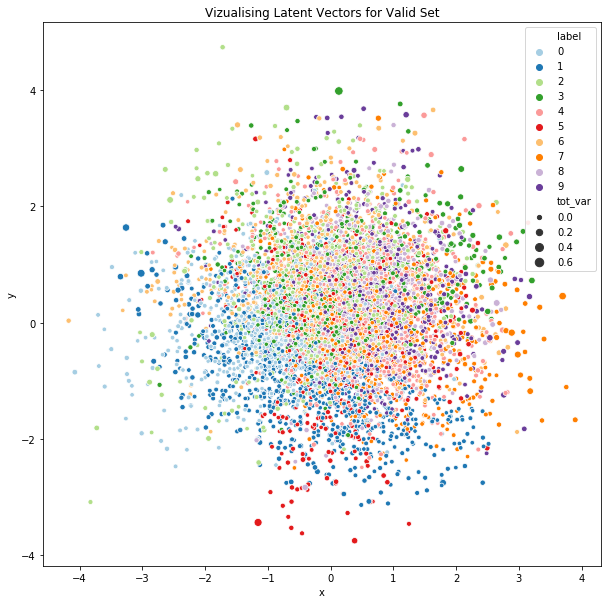

In [19]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="x", y="y", hue="label", size='tot_var', palette=sns.color_palette("Paired", 10), data=df)
plt.title('Vizualising Latent Vectors for Valid Set');

### Show Continuity of Latent Space

In [20]:
def draw_mnist_manifold_vae(model: nn.Module, label: int, size: int = 20):
    """This function takes a trained VAE with z_dim=2 and visualizes its latent space."""

    # generate a 2D point cloud of latent space using inverse CDF of Standard Gaussian.
    x_axes = ndist.ppf(np.linspace(0.01, 0.99, size))
    y_axes = ndist.ppf(np.linspace(0.01, 0.99, size))

    # preparing input to decoder.
    z = []
    for i, y in enumerate(x_axes):
        for j, x in enumerate(y_axes):
            z.append(torch.Tensor([x, y]))
    z = torch.stack(z)
    
    # decoding latent vectors
    preds = model.decode(z, torch.empty(z.shape[0], device=z.device).fill_(label)).detach().sigmoid()
    
    # rendering a single image from predictions.
    grid = make_grid(preds, pad_value=1, padding=1, nrow=size)[0].numpy()
    
    # showing the image.
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title('2D Latent Space')
    plt.show()

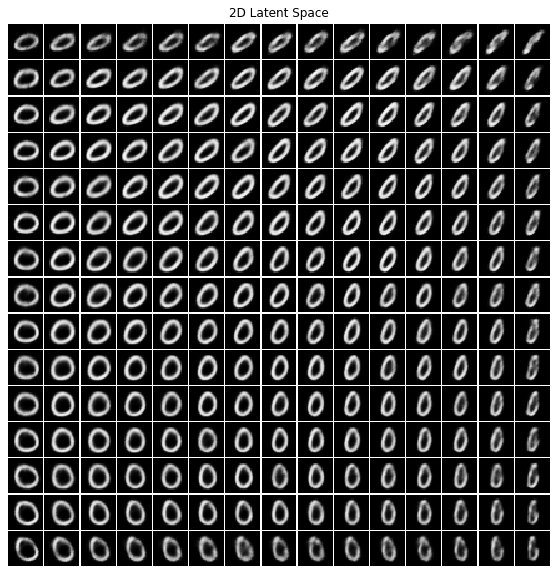

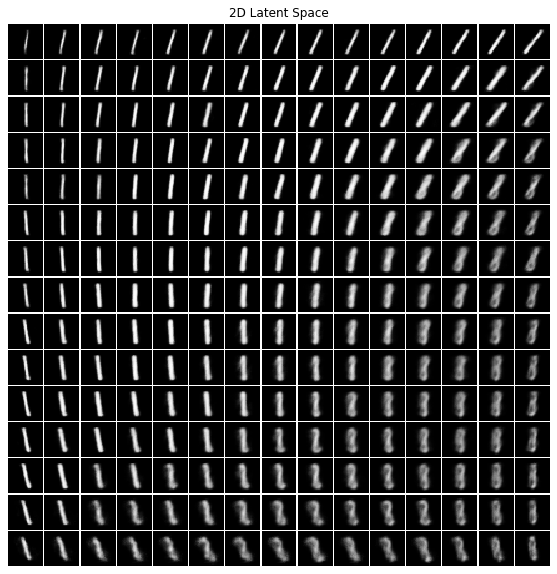

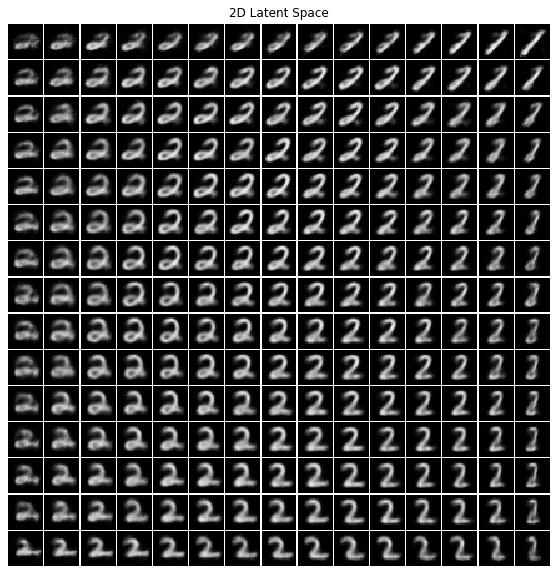

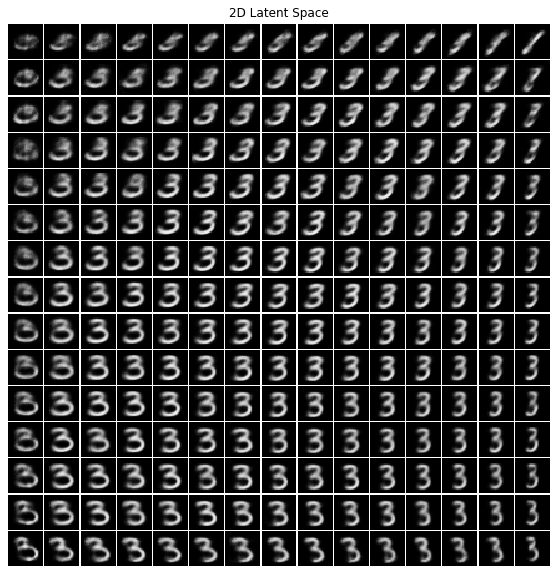

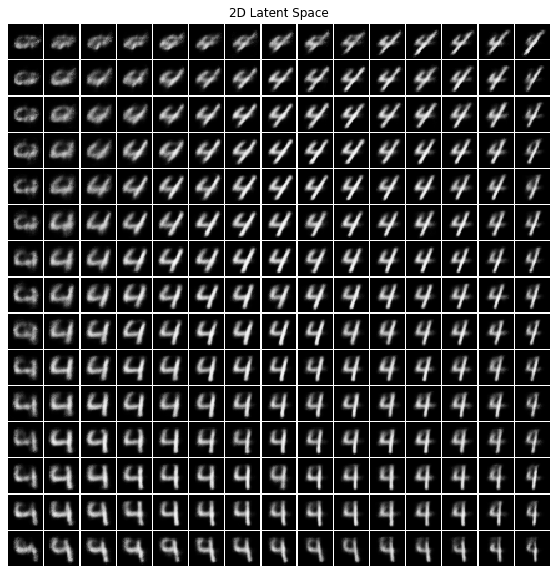

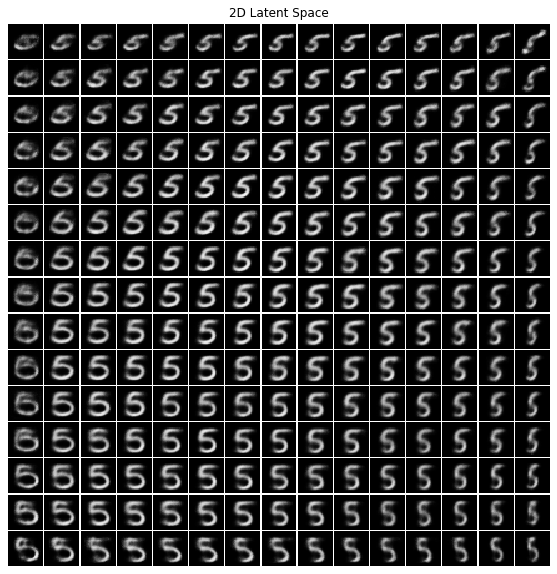

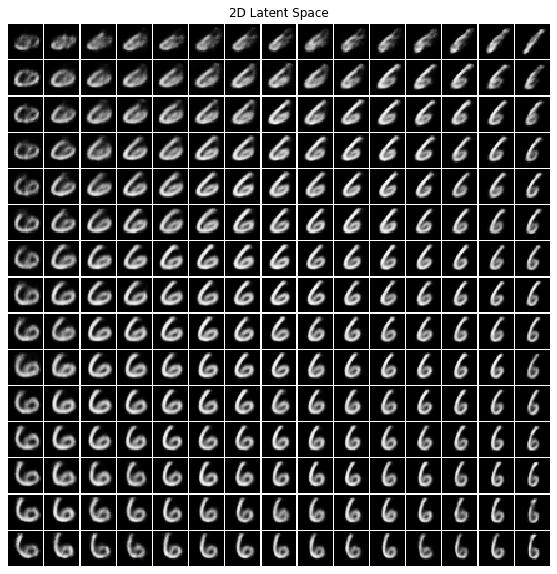

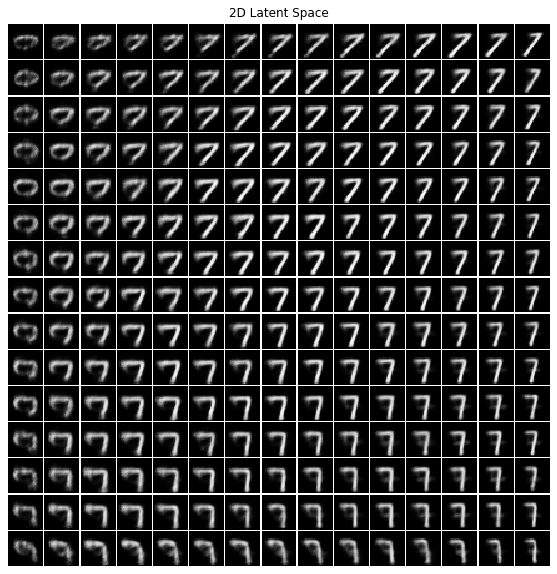

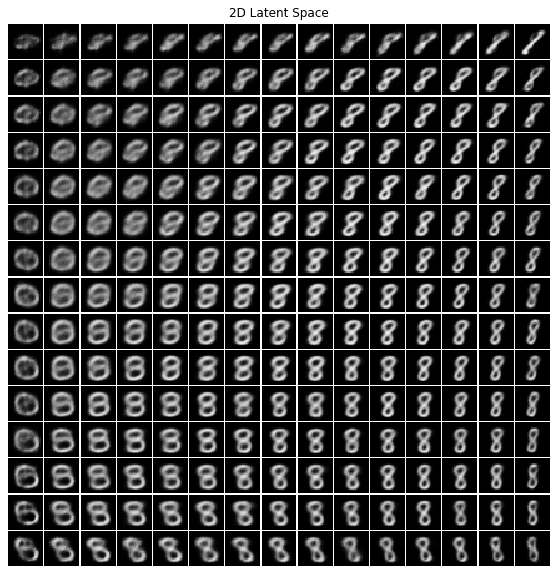

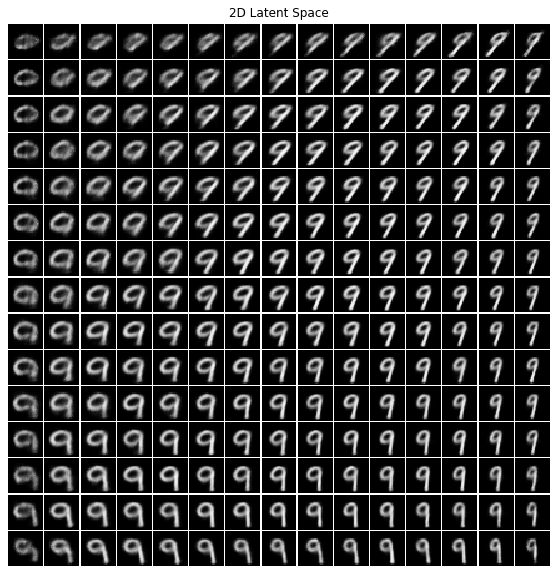

In [21]:
for label in range(10):
    draw_mnist_manifold_vae(vae.cpu(), label, size=15);

### Generating Digits with Same Hadnwritting

Here we fix Z and vary Y to generate different digits with same style.

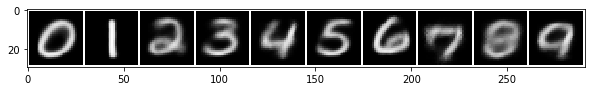

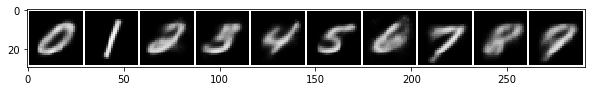

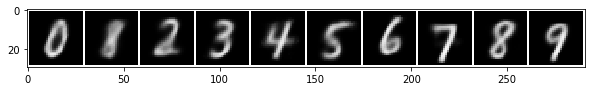

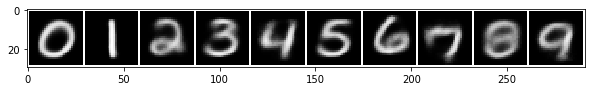

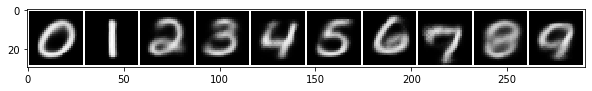

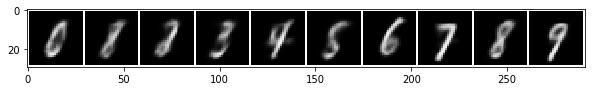

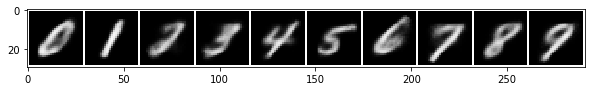

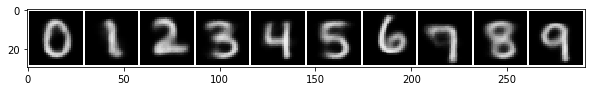

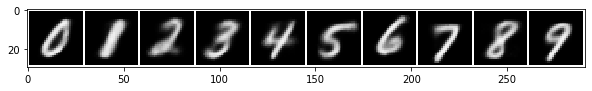

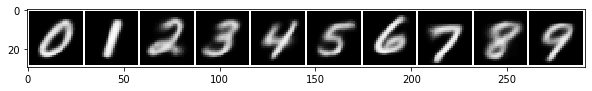

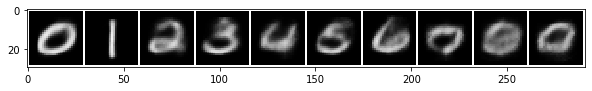

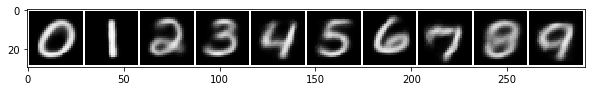

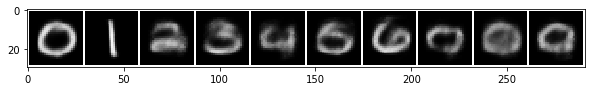

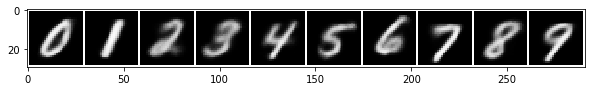

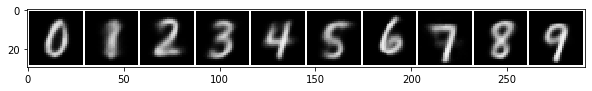

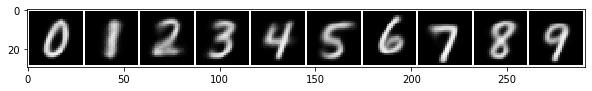

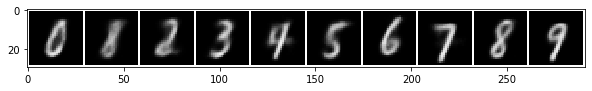

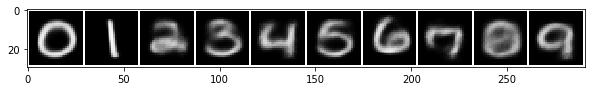

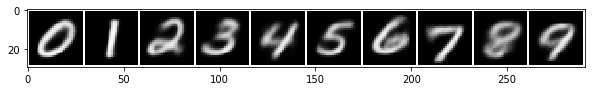

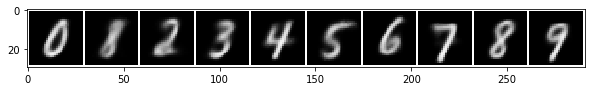

In [22]:
for i in range(20):
    z_ = torch.empty(2).normal_(0, 1).repeat(N_CLASSES, 1)

    y = torch.Tensor([i % N_CLASSES for i in range(N_CLASSES)])

    images = vae.decode(z_, y).sigmoid().detach()

    grid = make_grid(images, pad_value=1, padding=1, nrow=10)[0].detach().numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(grid, cmap='gray');